In [2]:
%run SAT_help_functions.ipynb

In [3]:
def get_RT_quantile_sub(df, correct, corrects, cond, conds, rt, quantiles = [.1, .3, .5, .7, .9]):
    
    # RT quantiles
    #print(df)
    #print(correct)
    #print(corrects[0])
    df_cor = df.loc[df[correct]==corrects[0]]
    RT_cor_s = df_cor.loc[df_cor[cond]==conds[0]][rt].quantile(q=quantiles)
    RT_cor_a = df_cor.loc[df_cor[cond]==conds[1]][rt].quantile(q=quantiles)
    
    df_err = df.loc[df[correct]==corrects[1]]
    RT_err_s = df_err.loc[df_err[cond]==conds[0]][rt].quantile(q=quantiles)
    RT_err_a = df_err.loc[df_err[cond]==conds[1]][rt].quantile(q=quantiles)
    
    # number of trials
    num_cor_s = len(df_cor.loc[df_cor[cond]==conds[0]])
    num_cor_a = len(df_cor.loc[df_cor[cond]==conds[1]])

    num_err_s = len(df_err.loc[df_err[cond]==conds[0]])
    num_err_a = len(df_err.loc[df_err[cond]==conds[1]])
    
    return RT_cor_s, RT_cor_a, RT_err_s, RT_err_a, [num_cor_s,num_cor_a,num_err_s,num_err_a]

def get_RT_quantile(dataset, data_dir, sample_size, correct, corrects, cond, conds, rt, quantiles = [.1, .3, .5, .7, .9]):

    RT_cor_ss, RT_cor_as, RT_err_ss, RT_err_as, nums = np.zeros((sample_size,5)),np.zeros((sample_size,5)),np.zeros((sample_size,5)),np.zeros((sample_size,5)),np.zeros((sample_size,4))
    for i in range(sample_size):
        #print(i)
        path = os.path.join(data_dir+str(i+1)+".csv")
        df = pd.read_csv(path, sep = ",")
        #print(df)
        if dataset=="Lerche2017":
            df = df[df["Time"]<30]
        else:
            df = df[df["Time"]<5]
        
        #print(df)
        RT_cor_s, RT_cor_a, RT_err_s, RT_err_a, num = get_RT_quantile_sub(
            df = df, rt = rt,
            correct = correct, corrects = corrects,
            cond = cond, conds = conds)
        #print(RT_cor_s)
        RT_cor_ss[i,:] = RT_cor_s
        RT_cor_as[i,:] = RT_cor_a
        RT_err_ss[i,:] = RT_err_s
        RT_err_as[i,:] = RT_err_a
        nums[i,:] = num
        
        #print(RT_err_s)

    
    return np.nanmean(RT_cor_ss, axis = 0), np.nanmean(RT_cor_as, axis = 0), np.nanmean(RT_err_ss, axis = 0), np.nanmean(RT_err_as, axis = 0), np.nanmean(nums, axis = 0)

def get_all_RT_quantile(dataset, data_dir, sample_size, correct, corrects, cond, conds, rt, quantiles = [.1, .3, .5, .7, .9]):

    RT_cor_ss, RT_cor_as, RT_err_ss, RT_err_as, nums = np.zeros((sample_size,5)),np.zeros((sample_size,5)),np.zeros((sample_size,5)),np.zeros((sample_size,5)),np.zeros((sample_size,4))
    for i in range(sample_size):
        #print(i)
        path = os.path.join(data_dir+str(i+1)+".csv")
        df = pd.read_csv(path, sep = ",")
        #print(df)
        #print(dataset)
        if dataset=="Lerche2017":
            df = df[df["Time"]<30]
        else:
            df = df[df["Time"]<5]
        
        #print(df)
        RT_cor_s, RT_cor_a, RT_err_s, RT_err_a, num = get_RT_quantile_sub(
            df = df, rt = rt,
            correct = correct, corrects = corrects,
            cond = cond, conds = conds)
        #print(RT_cor_s)
        RT_cor_ss[i,:] = RT_cor_s
        RT_cor_as[i,:] = RT_cor_a
        RT_err_ss[i,:] = RT_err_s
        RT_err_as[i,:] = RT_err_a
        nums[i,:] = num
        
        #print(RT_err_s)

    
    return RT_cor_ss, RT_cor_as, RT_err_ss, RT_err_as, nums


In [4]:
params = np.array(pd.read_csv("Parameter Estimates/DDM2v2a2terresultWagenmakers2008.csv"))[0,1:7]

In [5]:

def get_RT_quantile_DDM_sub(params, T_dur=5):

    Vspeed,Vacc, Bspeed,Bacc,tSpeed,tAcc = params[0],params[1],params[2],params[3],params[4],params[5]
    
    model = Model(name='Simple model (fitted)',
                      drift=DriftConstantSpeedAcc(Vspeed=Vspeed, Vacc=Vacc), 
                      noise=NoiseConstant(noise=1),
                      bound=BoundSpeedAcc(Bspeed=Bspeed,Bacc=Bacc),
                      overlay=NondecisionSpeedAcc(tSpeed=tSpeed,tAcc=tAcc),
                      dx=.001, dt=.001, T_dur=T_dur)
    sol_s = model.solve({'Cond':'Speed'})
    samp_s = sol_s.resample(1000)
    data_s = samp_s.to_pandas_dataframe(drop_undecided = True)

    sol_a = model.solve({'Cond':'Accuracy'})
    samp_a = sol_a.resample(1000)
    data_a = samp_a.to_pandas_dataframe(drop_undecided = True)

    data = pd.concat((data_s, data_a))

    return get_RT_quantile_sub(data, 'choice', [1,0], 'Cond', ['Speed', 'Accuracy'], 'RT')

def get_RT_quantile_DDM(dataset, sample_size, correct, corrects, cond, conds, rt, T_dur=5, freq = 1, quantiles = [.1, .3, .5, .7, .9]):

    RT_cor_ss, RT_cor_as, RT_err_ss, RT_err_as, nums = np.zeros((sample_size,5)),np.zeros((sample_size,5)),np.zeros((sample_size,5)),np.zeros((sample_size,5)),np.zeros((sample_size,4))
    if dataset=="Lerche2017":
        T_dur=30
    for i in range(sample_size):
        #print(i)
        params = np.array(pd.read_csv("Parameter Estimates/DDM2v2a2terresult"+dataset+".csv"))[i,1:7]
        if dataset=="Wagenmakers2008":
            params = pd.read_csv("Parameter Estimates/DDM2v2a2terresultWagenmakers2008.csv")
            params = params[params["Frequency"]==freq]
            params = np.array(params)[i,1:7]
        RT_cor_s, RT_cor_a, RT_err_s, RT_err_a, num = get_RT_quantile_DDM_sub(params = params,T_dur=T_dur)
        #print(RT_err_a)
        RT_cor_ss[i,:] = RT_cor_s
        RT_cor_as[i,:] = RT_cor_a
        RT_err_ss[i,:] = RT_err_s
        RT_err_as[i,:] = RT_err_a
        nums[i,:] = num
    
    return np.nanmean(RT_cor_ss, axis = 0), np.nanmean(RT_cor_as, axis = 0), np.nanmean(RT_err_ss, axis = 0), np.nanmean(RT_err_as, axis = 0), np.nanmean(nums, axis = 0)

def get_all_RT_quantile_DDM(dataset, sample_size, correct, corrects, cond, conds, rt, T_dur=5, freq = 1, quantiles = [.1, .3, .5, .7, .9]):

    RT_cor_ss, RT_cor_as, RT_err_ss, RT_err_as, nums = np.zeros((sample_size,5)),np.zeros((sample_size,5)),np.zeros((sample_size,5)),np.zeros((sample_size,5)),np.zeros((sample_size,4))
    if dataset=="Lerche2017":
        T_dur=30
    for i in range(sample_size):
        #print(i)
        params = np.array(pd.read_csv("Parameter Estimates/DDM2v2a2terresult"+dataset+".csv"))[i,1:7]
        if dataset=="Wagenmakers2008":
            params = pd.read_csv("Parameter Estimates/DDM2v2a2terresultWagenmakers2008.csv")
            params = params[params["Frequency"]==freq]
            params = np.array(params)[i,1:7]
        RT_cor_s, RT_cor_a, RT_err_s, RT_err_a, num = get_RT_quantile_DDM_sub(params = params,T_dur=T_dur)
        #print(RT_err_a)
        RT_cor_ss[i,:] = RT_cor_s
        RT_cor_as[i,:] = RT_cor_a
        RT_err_ss[i,:] = RT_err_s
        RT_err_as[i,:] = RT_err_a
        nums[i,:] = num
    
    return RT_cor_ss, RT_cor_as, RT_err_ss, RT_err_as, nums

def DDM_QP_plot(dataset, sample_size,ax=None,correct = 'Correct',corrects = [True, False],
                    cond = 'Cond', conds = ['Speed', 'Accuracy'],rt = 'Time'):
    if ax is None:
        ax = plt.gca()
    
    quantiles = [.1, .3, .5, .7, .9]
    ## behavioral data
    data_dir = "/Users/wangjiashun/Desktop/Research_on_SAT/datasets/transformed/"+dataset+"/sub"
    RT_cor_s, RT_cor_a, RT_err_s, RT_err_a, nums = get_RT_quantile(dataset=dataset, data_dir = data_dir,sample_size= sample_size, 
                                                                   correct = correct, corrects = corrects,
                                                                   cond = cond, conds = conds, rt = rt)
    
    ax.plot([nums[0]/(nums[0]+nums[2])]*5, RT_cor_s,"o", color = 'black', fillstyle = 'none',label="Data")
    ax.plot([nums[1]/(nums[1]+nums[3])]*5, RT_cor_a,"o", color = 'black', fillstyle = 'none')
    ax.plot([nums[2]/(nums[0]+nums[2])]*5, RT_err_s,"o", color = 'black', fillstyle = 'none')
    ax.plot([nums[3]/(nums[1]+nums[3])]*5, RT_err_a,"o", color = 'black', fillstyle = 'none')
    
    ## data generated from model
    RT_cor_s, RT_cor_a, RT_err_s, RT_err_a, nums = get_RT_quantile_DDM(dataset=dataset, sample_size= sample_size, 
                                                                   correct = correct, corrects = corrects,
                                                                   cond = cond, conds = conds, rt = rt)
    
    ax.plot([nums[0]/(nums[0]+nums[2])]*5, RT_cor_s,"x", color = '#0E8585', fillstyle = 'none',label="DDM")
    ax.plot([nums[1]/(nums[1]+nums[3])]*5, RT_cor_a,"x", color = '#0E8585', fillstyle = 'none')
    ax.plot([nums[2]/(nums[0]+nums[2])]*5, RT_err_s,"x", color = '#0E8585', fillstyle = 'none')
    ax.plot([nums[3]/(nums[1]+nums[3])]*5, RT_err_a,"x", color = '#0E8585', fillstyle = 'none')
    
    # limits
    ax.set_xlim(0,1)
    ax.set_ylim(0,)
        
    #ax.set_xlabel("Probability of Response")
    ax.set_ylabel("RT",fontsize = 16)
    ax.spines[['right', 'top']].set_visible(False)
    ax.tick_params(axis='both', which='major', labelsize=14)
    return(ax)
#DDM_QP_plot()

In [28]:
def get_RT_quantile_OUM2v2k2ter_sub(params, T_dur=5):

    Vspeed,Vacc, Kspeed,Kacc,B,tSpeed,tAcc = params[0],params[1],params[2],params[3],params[4],params[5],params[6]

    model = Model(name='Simple model (fitted)',
                      drift=DriftBothSpeedAcc(Vspeed=Vspeed, Vacc=Vacc, Kspeed=Kspeed, Kacc=Kacc),                              
                      noise=NoiseConstant(noise=1),
                      bound=BoundConstant(B=B),
                      overlay=NondecisionSpeedAcc(tSpeed=tSpeed,tAcc=tAcc),
                      dx=.001, dt=.001, T_dur=T_dur)
    sol_s = model.solve({'Cond':'Speed'})
    samp_s = sol_s.resample(1000)
    data_s = samp_s.to_pandas_dataframe(drop_undecided = True)

    sol_a = model.solve({'Cond':'Accuracy'})
    samp_a = sol_a.resample(1000)
    data_a = samp_a.to_pandas_dataframe(drop_undecided = True)

    data = pd.concat((data_s, data_a))
    #print(data)
    return get_RT_quantile_sub(data, 'choice', [1,0], 'Cond', ['Speed', 'Accuracy'], 'RT')
#get_RT_quantile_OUM2v2k2ter_sub(params = np.array(params_all)[0,1:8])

def get_RT_quantile_OUM2v2k2ter(dataset, sample_size, correct, corrects, cond, conds, rt, T_dur=5, freq = 1, quantiles = [.1, .3, .5, .7, .9]):

    RT_cor_ss, RT_cor_as, RT_err_ss, RT_err_as, nums = np.zeros((sample_size,5)),np.zeros((sample_size,5)),np.zeros((sample_size,5)),np.zeros((sample_size,5)),np.zeros((sample_size,4))
    if dataset=="Lerche2017":
        T_dur=30
    for i in range(sample_size):
        params = np.array(pd.read_csv("Parameter Estimates/OUM2v2k2terresult"+dataset+".csv"))[i,1:8]
        if dataset=="Wagenmakers2008":
            params = pd.read_csv("Parameter Estimates/OUM2v2k2terresultWagenmakers2008.csv")
            params = params[params["Frequency"]==freq]
            params = np.array(params)[i,1:8]
            
        RT_cor_s, RT_cor_a, RT_err_s, RT_err_a, num = get_RT_quantile_OUM2v2k2ter_sub(params = params,T_dur=T_dur)
        #print(RT_err_a)
        RT_cor_ss[i,:] = RT_cor_s
        RT_cor_as[i,:] = RT_cor_a
        RT_err_ss[i,:] = RT_err_s
        RT_err_as[i,:] = RT_err_a
        nums[i,:] = num
    
    return np.nanmean(RT_cor_ss, axis = 0), np.nanmean(RT_cor_as, axis = 0), np.nanmean(RT_err_ss, axis = 0), np.nanmean(RT_err_as, axis = 0), np.nanmean(nums, axis = 0)

#RT_cor_s, RT_cor_a, RT_err_s, RT_err_a, nums = get_RT_quantile_OUM2v2k2ter(params_all = params_all,sample_size= sample_size, correct = correct, corrects = corrects,
#        cond = cond, conds = conds, rt = rt)

def get_all_RT_quantile_OUM2v2k2ter(dataset, sample_size, correct, corrects, cond, conds, rt, T_dur=5, freq = 1, quantiles = [.1, .3, .5, .7, .9]):

    RT_cor_ss, RT_cor_as, RT_err_ss, RT_err_as, nums = np.zeros((sample_size,5)),np.zeros((sample_size,5)),np.zeros((sample_size,5)),np.zeros((sample_size,5)),np.zeros((sample_size,4))
    if dataset=="Lerche2017":
        T_dur=30
    for i in range(sample_size):
        params = np.array(pd.read_csv("Parameter Estimates/OUM2v2k2terresult"+dataset+".csv"))[i,1:8]
        if dataset=="Wagenmakers2008":
            params = pd.read_csv("Parameter Estimates/OUM2v2k2terresultWagenmakers2008.csv")
            params = params[params["Frequency"]==freq]
            params = np.array(params)[i,1:8]
            
        RT_cor_s, RT_cor_a, RT_err_s, RT_err_a, num = get_RT_quantile_OUM2v2k2ter_sub(params = params,T_dur=T_dur)
        #print(RT_err_a)
        RT_cor_ss[i,:] = RT_cor_s
        RT_cor_as[i,:] = RT_cor_a
        RT_err_ss[i,:] = RT_err_s
        RT_err_as[i,:] = RT_err_a
        nums[i,:] = num
    
    return RT_cor_ss, RT_cor_as, RT_err_ss, RT_err_as, nums

def OUM2v2k2ter_QP_plot(dataset, sample_size,ax=None, correct = 'Correct',corrects = [True, False],
                    cond = 'Cond', conds = ['Speed', 'Accuracy'],rt = 'Time'):
    if ax is None:
        ax = plt.gca()
    
    quantiles = [.1, .3, .5, .7, .9]
    ## behavioral data
    data_dir = "/Users/wangjiashun/Desktop/Research_on_SAT/datasets/transformed/"+dataset+"/sub"
    RT_cor_s, RT_cor_a, RT_err_s, RT_err_a, nums = get_RT_quantile(dataset=dataset, data_dir = data_dir,sample_size= sample_size, 
                                                                   correct = correct, corrects = corrects,
                                                                   cond = cond, conds = conds, rt = rt)
    
    ax.plot([nums[0]/(nums[0]+nums[2])]*5, RT_cor_s,"o", color = 'black', fillstyle = 'none')
    ax.plot([nums[1]/(nums[1]+nums[3])]*5, RT_cor_a,"o", color = 'black', fillstyle = 'none')
    ax.plot([nums[2]/(nums[0]+nums[2])]*5, RT_err_s,"o", color = 'black', fillstyle = 'none')
    ax.plot([nums[3]/(nums[1]+nums[3])]*5, RT_err_a,"o", color = 'black', fillstyle = 'none')
    
    ## data generated from model
    RT_cor_s, RT_cor_a, RT_err_s, RT_err_a, nums = get_RT_quantile_OUM2v2k2ter(dataset=dataset, sample_size= sample_size, 
                                                                   correct = correct, corrects = corrects,
                                                                   cond = cond, conds = conds, rt = rt)
    
    ax.plot([nums[0]/(nums[0]+nums[2])]*5, RT_cor_s,"x", color = '#830783', fillstyle = 'none',label="OUM")
    ax.plot([nums[1]/(nums[1]+nums[3])]*5, RT_cor_a,"x", color = '#830783', fillstyle = 'none')
    ax.plot([nums[2]/(nums[0]+nums[2])]*5, RT_err_s,"x", color = '#830783', fillstyle = 'none')
    ax.plot([nums[3]/(nums[1]+nums[3])]*5, RT_err_a,"x", color = '#830783', fillstyle = 'none')
    #print(RT_err_s)
    # limits
    ax.set_xlim(0,1)
    ax.set_ylim(0,max(RT_err_a)+0.2)
    #HHHH    
    #ax.set_xlabel("Probability of Response")
    ax.set_ylabel("RT",fontsize = 16)
    ax.spines[['right', 'top']].set_visible(False)
    ax.tick_params(axis='both', which='major', labelsize=14)
    return(ax)


In [7]:
def get_RT_quantile_DDM2v2a2c2ter_sub(params, T_dur=5):

    Vspeed, Vacc, BSpeed,BAcc,cSpeed,cAcc, tSpeed,tAcc = params[0],params[1],params[2],params[3],params[4],params[5],params[6],params[7]

    model = Model(name='Simple model (fitted)',
                      drift=DriftConstantSpeedAcc(Vspeed=Vspeed, Vacc=Vacc),                              
                      noise=NoiseConstant(noise=1),
                      bound=BoundCollapsingLinearSAT(BSpeed=BSpeed, BAcc = BAcc, cSpeed = cSpeed, cAcc=cAcc),
                      overlay=NondecisionSpeedAcc(tSpeed=tSpeed,tAcc=tAcc),
                      dx=.001, dt=.001, T_dur=T_dur)
    sol_s = model.solve({'Cond':'Speed'})
    samp_s = sol_s.resample(1000)
    data_s = samp_s.to_pandas_dataframe(drop_undecided = True)

    sol_a = model.solve({'Cond':'Accuracy'})
    samp_a = sol_a.resample(1000)
    data_a = samp_a.to_pandas_dataframe(drop_undecided = True)

    data = pd.concat((data_s, data_a))
    #print(data)
    return get_RT_quantile_sub(data, 'choice', [1,0], 'Cond', ['Speed', 'Accuracy'], 'RT')

def get_RT_quantile_DDM2v2a2c2ter(dataset, sample_size, correct, corrects, cond, conds, rt, T_dur=5, freq = 1, quantiles = [.1, .3, .5, .7, .9]):

    RT_cor_ss, RT_cor_as, RT_err_ss, RT_err_as, nums = np.zeros((sample_size,5)),np.zeros((sample_size,5)),np.zeros((sample_size,5)),np.zeros((sample_size,5)),np.zeros((sample_size,4))
    if dataset=="Lerche2017":
        T_dur=30
    for i in range(sample_size):
        params = np.array(pd.read_csv("Parameter Estimates/DDM2v2a2c2terresult"+dataset+".csv"))[i,1:9]
        if dataset=="Wagenmakers2008":
            params = pd.read_csv("Parameter Estimates/DDM2v2a2c2terresultWagenmakers2008.csv")
            params = params[params["Frequency"]==freq]
            params = np.array(params)[i,1:9]
            
        RT_cor_s, RT_cor_a, RT_err_s, RT_err_a, num = get_RT_quantile_DDM2v2a2c2ter_sub(params = params,T_dur=T_dur)
        #print(RT_err_a)
        RT_cor_ss[i,:] = RT_cor_s
        RT_cor_as[i,:] = RT_cor_a
        RT_err_ss[i,:] = RT_err_s
        RT_err_as[i,:] = RT_err_a
        nums[i,:] = num
    
    return np.nanmean(RT_cor_ss, axis = 0), np.nanmean(RT_cor_as, axis = 0), np.nanmean(RT_err_ss, axis = 0), np.nanmean(RT_err_as, axis = 0), np.nanmean(nums, axis = 0)

#RT_cor_s, RT_cor_a, RT_err_s, RT_err_a, nums = get_RT_quantile_OUM2v2k2ter(params_all = params_all,sample_size= sample_size, correct = correct, corrects = corrects,
#        cond = cond, conds = conds, rt = rt)

def get_all_RT_quantile_DDM2v2a2c2ter(dataset, sample_size, correct, corrects, cond, conds, rt, T_dur=5, freq = 1, quantiles = [.1, .3, .5, .7, .9]):

    RT_cor_ss, RT_cor_as, RT_err_ss, RT_err_as, nums = np.zeros((sample_size,5)),np.zeros((sample_size,5)),np.zeros((sample_size,5)),np.zeros((sample_size,5)),np.zeros((sample_size,4))
    if dataset=="Lerche2017":
        T_dur=30
    for i in range(sample_size):
        params = np.array(pd.read_csv("Parameter Estimates/DDM2v2a2c2terresult"+dataset+".csv"))[i,1:9]
        if dataset=="Wagenmakers2008":
            params = pd.read_csv("Parameter Estimates/DDM2v2a2c2terresultWagenmakers2008.csv")
            params = params[params["Frequency"]==freq]
            params = np.array(params)[i,1:9]
            
        RT_cor_s, RT_cor_a, RT_err_s, RT_err_a, num = get_RT_quantile_DDM2v2a2c2ter_sub(params = params,T_dur=T_dur)
        #print(RT_err_a)
        RT_cor_ss[i,:] = RT_cor_s
        RT_cor_as[i,:] = RT_cor_a
        RT_err_ss[i,:] = RT_err_s
        RT_err_as[i,:] = RT_err_a
        nums[i,:] = num
    
    return RT_cor_ss, RT_cor_as, RT_err_ss, RT_err_as, nums

def DDM2v2a2c2ter_QP_plot(dataset, sample_size,ax=None, correct = 'Correct',corrects = [True, False],
                    cond = 'Cond', conds = ['Speed', 'Accuracy'],rt = 'Time'):
    if ax is None:
        ax = plt.gca()
    
    quantiles = [.1, .3, .5, .7, .9]
    ## behavioral data
    data_dir = "/Users/wangjiashun/Desktop/Research_on_SAT/datasets/transformed/"+dataset+"/sub"
    RT_cor_s, RT_cor_a, RT_err_s, RT_err_a, nums = get_RT_quantile(dataset=dataset, data_dir = data_dir,sample_size= sample_size, 
                                                                   correct = correct, corrects = corrects,
                                                                   cond = cond, conds = conds, rt = rt)
    
    ax.plot([nums[0]/(nums[0]+nums[2])]*5, RT_cor_s,"o", color = 'black', fillstyle = 'none')
    ax.plot([nums[1]/(nums[1]+nums[3])]*5, RT_cor_a,"o", color = 'black', fillstyle = 'none')
    ax.plot([nums[2]/(nums[0]+nums[2])]*5, RT_err_s,"o", color = 'black', fillstyle = 'none')
    ax.plot([nums[3]/(nums[1]+nums[3])]*5, RT_err_a,"o", color = 'black', fillstyle = 'none')
    
    ## data generated from model
    RT_cor_s, RT_cor_a, RT_err_s, RT_err_a, nums = get_RT_quantile_DDM2v2a2c2ter(dataset=dataset, sample_size= sample_size, 
                                                                   correct = correct, corrects = corrects,
                                                                   cond = cond, conds = conds, rt = rt)
    
    ax.plot([nums[0]/(nums[0]+nums[2])]*5, RT_cor_s,"x", color = '#1f77b4', fillstyle = 'none',label="LCBM")
    ax.plot([nums[1]/(nums[1]+nums[3])]*5, RT_cor_a,"x", color = '#1f77b4', fillstyle = 'none')
    ax.plot([nums[2]/(nums[0]+nums[2])]*5, RT_err_s,"x", color = '#1f77b4', fillstyle = 'none')
    ax.plot([nums[3]/(nums[1]+nums[3])]*5, RT_err_a,"x", color = '#1f77b4', fillstyle = 'none')
    
    # limits
    ax.set_xlim(0,1)
    ax.set_ylim(0,)
        
    ax.set_xlabel("Probability of Response")
    ax.set_ylabel("RT")
    return(ax)


In [8]:
def get_RT_quantile_OUM2k2ter_sub(params, T_dur=5):

    V, Kspeed,Kacc,B,tSpeed,tAcc = params[0],params[1],params[2],params[3],params[4],params[5]

    model = Model(name='Simple model (fitted)',
                      drift=DriftKSpeedAcc(V=V, Kspeed=Kspeed, Kacc=Kacc),                              
                      noise=NoiseConstant(noise=1),
                      bound=BoundConstant(B=B),
                      overlay=NondecisionSpeedAcc(tSpeed=tSpeed,tAcc=tAcc),
                      dx=.001, dt=.001, T_dur=T_dur)
    sol_s = model.solve({'Cond':'Speed'})
    samp_s = sol_s.resample(1000)
    data_s = samp_s.to_pandas_dataframe(drop_undecided = True)

    sol_a = model.solve({'Cond':'Accuracy'})
    samp_a = sol_a.resample(1000)
    data_a = samp_a.to_pandas_dataframe(drop_undecided = True)

    data = pd.concat((data_s, data_a))
    #print(data)
    return get_RT_quantile_sub(data, 'choice', [1,0], 'Cond', ['Speed', 'Accuracy'], 'RT')
#get_RT_quantile_OUM2v2k2ter_sub(params = np.array(params_all)[0,1:8])

def get_RT_quantile_OUM2k2ter(dataset, sample_size, correct, corrects, cond, conds, rt, T_dur=5, freq = 1, quantiles = [.1, .3, .5, .7, .9]):

    RT_cor_ss, RT_cor_as, RT_err_ss, RT_err_as, nums = np.zeros((sample_size,5)),np.zeros((sample_size,5)),np.zeros((sample_size,5)),np.zeros((sample_size,5)),np.zeros((sample_size,4))
    if dataset=="Lerche2017":
        T_dur=30
    for i in range(sample_size):
        params = np.array(pd.read_csv("Parameter Estimates/OUM2k2terresult"+dataset+".csv"))[i,1:7]
        if dataset=="Wagenmakers2008":
            params = pd.read_csv("Parameter Estimates/OUM2k2terresultWagenmakers2008.csv")
            params = params[params["Frequency"]==freq]
            params = np.array(params)[i,1:7]
            
        RT_cor_s, RT_cor_a, RT_err_s, RT_err_a, num = get_RT_quantile_OUM2k2ter_sub(params = params,T_dur=T_dur)
        #print(RT_err_a)
        RT_cor_ss[i,:] = RT_cor_s
        RT_cor_as[i,:] = RT_cor_a
        RT_err_ss[i,:] = RT_err_s
        RT_err_as[i,:] = RT_err_a
        nums[i,:] = num
    
    return np.nanmean(RT_cor_ss, axis = 0), np.nanmean(RT_cor_as, axis = 0), np.nanmean(RT_err_ss, axis = 0), np.nanmean(RT_err_as, axis = 0), np.nanmean(nums, axis = 0)

#RT_cor_s, RT_cor_a, RT_err_s, RT_err_a, nums = get_RT_quantile_OUM2v2k2ter(params_all = params_all,sample_size= sample_size, correct = correct, corrects = corrects,
#        cond = cond, conds = conds, rt = rt)

def get_all_RT_quantile_OUM2k2ter(dataset, sample_size, correct, corrects, cond, conds, rt, T_dur=5, freq = 1, quantiles = [.1, .3, .5, .7, .9]):

    RT_cor_ss, RT_cor_as, RT_err_ss, RT_err_as, nums = np.zeros((sample_size,5)),np.zeros((sample_size,5)),np.zeros((sample_size,5)),np.zeros((sample_size,5)),np.zeros((sample_size,4))
    if dataset=="Lerche2017":
        T_dur=30
    for i in range(sample_size):
        params = np.array(pd.read_csv("Parameter Estimates/OUM2k2terresult"+dataset+".csv"))[i,1:7]
        if dataset=="Wagenmakers2008":
            params = pd.read_csv("Parameter Estimates/OUM2k2terresultWagenmakers2008.csv")
            params = params[params["Frequency"]==freq]
            params = np.array(params)[i,1:7]
            
        RT_cor_s, RT_cor_a, RT_err_s, RT_err_a, num = get_RT_quantile_OUM2k2ter_sub(params = params,T_dur=T_dur)
        #print(RT_err_a)
        RT_cor_ss[i,:] = RT_cor_s
        RT_cor_as[i,:] = RT_cor_a
        RT_err_ss[i,:] = RT_err_s
        RT_err_as[i,:] = RT_err_a
        nums[i,:] = num
    
    return RT_cor_ss, RT_cor_as, RT_err_ss, RT_err_as, nums

def OUM2k2ter_QP_plot(dataset, sample_size,ax=None, correct = 'Correct',corrects = [True, False],
                    cond = 'Cond', conds = ['Speed', 'Accuracy'],rt = 'Time'):
    if ax is None:
        ax = plt.gca()
    
    quantiles = [.1, .3, .5, .7, .9]
    ## behavioral data
    data_dir = "/Users/wangjiashun/Desktop/Research_on_SAT/datasets/transformed/"+dataset+"/sub"
    RT_cor_s, RT_cor_a, RT_err_s, RT_err_a, nums = get_RT_quantile(dataset=dataset, data_dir = data_dir,sample_size= sample_size, 
                                                                   correct = correct, corrects = corrects,
                                                                   cond = cond, conds = conds, rt = rt)
    
    ax.plot([nums[0]/(nums[0]+nums[2])]*5, RT_cor_s,"o", color = 'black', fillstyle = 'none')
    ax.plot([nums[1]/(nums[1]+nums[3])]*5, RT_cor_a,"o", color = 'black', fillstyle = 'none')
    ax.plot([nums[2]/(nums[0]+nums[2])]*5, RT_err_s,"o", color = 'black', fillstyle = 'none')
    ax.plot([nums[3]/(nums[1]+nums[3])]*5, RT_err_a,"o", color = 'black', fillstyle = 'none')
    
    ## data generated from model
    RT_cor_s, RT_cor_a, RT_err_s, RT_err_a, nums = get_RT_quantile_OUM2k2ter(dataset=dataset, sample_size= sample_size, 
                                                                   correct = correct, corrects = corrects,
                                                                   cond = cond, conds = conds, rt = rt)
    
    ax.plot([nums[0]/(nums[0]+nums[2])]*5, RT_cor_s,"x", color = '#1f77b4', fillstyle = 'none',label="OUM")
    ax.plot([nums[1]/(nums[1]+nums[3])]*5, RT_cor_a,"x", color = '#1f77b4', fillstyle = 'none')
    ax.plot([nums[2]/(nums[0]+nums[2])]*5, RT_err_s,"x", color = '#1f77b4', fillstyle = 'none')
    ax.plot([nums[3]/(nums[1]+nums[3])]*5, RT_err_a,"x", color = '#1f77b4', fillstyle = 'none')
    
    # limits
    ax.set_xlim(0,1)
    ax.set_ylim(0,)
        
    ax.set_xlabel("Probability of Response")
    ax.set_ylabel("RT")
    return(ax)


In [9]:
def get_RT_quantile_OUM2v2a2k2ter_sub(params, T_dur=5):

    Vspeed,Vacc, Kspeed,Kacc,Bspeed,Bacc, tSpeed,tAcc = params[0],params[1],params[2],params[3],params[4],params[5],params[6],params[7]

    model = Model(name='Simple model (fitted)',
                      drift=DriftBothSpeedAcc(Vspeed=Vspeed, Vacc=Vacc, Kspeed=Kspeed, Kacc=Kacc),                              
                      noise=NoiseConstant(noise=1),
                      bound=BoundSpeedAcc(Bspeed=Bspeed,Bacc=Bacc),
                      overlay=NondecisionSpeedAcc(tSpeed=tSpeed,tAcc=tAcc),
                      dx=.001, dt=.001, T_dur=T_dur)
    sol_s = model.solve({'Cond':'Speed'})
    samp_s = sol_s.resample(1000)
    data_s = samp_s.to_pandas_dataframe(drop_undecided = True)

    sol_a = model.solve({'Cond':'Accuracy'})
    samp_a = sol_a.resample(1000)
    data_a = samp_a.to_pandas_dataframe(drop_undecided = True)

    data = pd.concat((data_s, data_a))
    #print(data)
    return get_RT_quantile_sub(data, 'choice', [1,0], 'Cond', ['Speed', 'Accuracy'], 'RT')
#get_RT_quantile_OUM2v2k2ter_sub(params = np.array(params_all)[0,1:8])

def get_RT_quantile_OUM2v2a2k2ter(dataset, sample_size, correct, corrects, cond, conds, rt, T_dur=5, freq = 1, quantiles = [.1, .3, .5, .7, .9]):

    RT_cor_ss, RT_cor_as, RT_err_ss, RT_err_as, nums = np.zeros((sample_size,5)),np.zeros((sample_size,5)),np.zeros((sample_size,5)),np.zeros((sample_size,5)),np.zeros((sample_size,4))
    if dataset=="Lerche2017":
        T_dur=30
    for i in range(sample_size):
        params = np.array(pd.read_csv("Parameter Estimates/OUM2v2a2k2terresult"+dataset+".csv"))[i,1:9]
        if dataset=="Wagenmakers2008":
            params = pd.read_csv("Parameter Estimates/OUM2v2a2k2terresultWagenmakers2008.csv")
            params = params[params["Frequency"]==freq]
            params = np.array(params)[i,1:9]
            
        RT_cor_s, RT_cor_a, RT_err_s, RT_err_a, num = get_RT_quantile_OUM2v2a2k2ter_sub(params = params,T_dur=T_dur)
        #print(RT_err_a)
        RT_cor_ss[i,:] = RT_cor_s
        RT_cor_as[i,:] = RT_cor_a
        RT_err_ss[i,:] = RT_err_s
        RT_err_as[i,:] = RT_err_a
        nums[i,:] = num
    
    return np.nanmean(RT_cor_ss, axis = 0), np.nanmean(RT_cor_as, axis = 0), np.nanmean(RT_err_ss, axis = 0), np.nanmean(RT_err_as, axis = 0), np.nanmean(nums, axis = 0)

#RT_cor_s, RT_cor_a, RT_err_s, RT_err_a, nums = get_RT_quantile_OUM2v2k2ter(params_all = params_all,sample_size= sample_size, correct = correct, corrects = corrects,
#        cond = cond, conds = conds, rt = rt)

def get_all_RT_quantile_OUM2v2a2k2ter(dataset, sample_size, correct, corrects, cond, conds, rt, T_dur=5, freq = 1, quantiles = [.1, .3, .5, .7, .9]):

    RT_cor_ss, RT_cor_as, RT_err_ss, RT_err_as, nums = np.zeros((sample_size,5)),np.zeros((sample_size,5)),np.zeros((sample_size,5)),np.zeros((sample_size,5)),np.zeros((sample_size,4))
    if dataset=="Lerche2017":
        T_dur=30
    for i in range(sample_size):
        params = np.array(pd.read_csv("Parameter Estimates/OUM2v2a2k2terresult"+dataset+".csv"))[i,1:9]
        if dataset=="Wagenmakers2008":
            params = pd.read_csv("Parameter Estimates/OUM2v2a2k2terresultWagenmakers2008.csv")
            params = params[params["Frequency"]==freq]
            params = np.array(params)[i,1:9]
            
        RT_cor_s, RT_cor_a, RT_err_s, RT_err_a, num = get_RT_quantile_OUM2v2a2k2ter_sub(params = params,T_dur=T_dur)
        #print(RT_err_a)
        RT_cor_ss[i,:] = RT_cor_s
        RT_cor_as[i,:] = RT_cor_a
        RT_err_ss[i,:] = RT_err_s
        RT_err_as[i,:] = RT_err_a
        nums[i,:] = num
    
    return RT_cor_ss, RT_cor_as, RT_err_ss, RT_err_as, nums

def OUM2v2a2k2ter_QP_plot(dataset, sample_size,ax=None, correct = 'Correct',corrects = [True, False],
                    cond = 'Cond', conds = ['Speed', 'Accuracy'],rt = 'Time'):
    if ax is None:
        ax = plt.gca()
    
    quantiles = [.1, .3, .5, .7, .9]
    ## behavioral data
    data_dir = "/Users/wangjiashun/Desktop/Research_on_SAT/datasets/transformed/"+dataset+"/sub"
    RT_cor_s, RT_cor_a, RT_err_s, RT_err_a, nums = get_RT_quantile(dataset=dataset, data_dir = data_dir,sample_size= sample_size, 
                                                                   correct = correct, corrects = corrects,
                                                                   cond = cond, conds = conds, rt = rt)
    
    ax.plot([nums[0]/(nums[0]+nums[2])]*5, RT_cor_s,"o", color = 'black', fillstyle = 'none')
    ax.plot([nums[1]/(nums[1]+nums[3])]*5, RT_cor_a,"o", color = 'black', fillstyle = 'none')
    ax.plot([nums[2]/(nums[0]+nums[2])]*5, RT_err_s,"o", color = 'black', fillstyle = 'none')
    ax.plot([nums[3]/(nums[1]+nums[3])]*5, RT_err_a,"o", color = 'black', fillstyle = 'none')
    
    ## data generated from model
    RT_cor_s, RT_cor_a, RT_err_s, RT_err_a, nums = get_RT_quantile_OUM2v2a2k2ter(dataset=dataset, sample_size= sample_size, 
                                                                   correct = correct, corrects = corrects,
                                                                   cond = cond, conds = conds, rt = rt)
    
    ax.plot([nums[0]/(nums[0]+nums[2])]*5, RT_cor_s,"x", color = '#1f77b4', fillstyle = 'none',label="OUM")
    ax.plot([nums[1]/(nums[1]+nums[3])]*5, RT_cor_a,"x", color = '#1f77b4', fillstyle = 'none')
    ax.plot([nums[2]/(nums[0]+nums[2])]*5, RT_err_s,"x", color = '#1f77b4', fillstyle = 'none')
    ax.plot([nums[3]/(nums[1]+nums[3])]*5, RT_err_a,"x", color = '#1f77b4', fillstyle = 'none')
    
    # limits
    ax.set_xlim(0,1)
    ax.set_ylim(0,)
        
    ax.set_xlabel("Probability of Response")
    ax.set_ylabel("RT")
    return(ax)


In [10]:
def DDM2v2a2c2ter_OUM_QP_plot(dataset,sample_size, correct = 'Correct',corrects = [True, False],
                    cond = 'Cond', conds = ['Speed', 'Accuracy'],rt = 'Time',ax=None):
    if ax is None:
        ax = plt.gca()
    DDM2v2a2c2ter_QP_plot(dataset, sample_size, ax=ax)
    OUM2v2k2ter_QP_plot(dataset, sample_size, ax=ax)
    ax.set_title(dataset)
    ax.set_xlabel("")
    return(ax)
#DDM_OUM_QP_plot(dataset)

In [11]:
def DDM_OUM2v2a2k2ter_QP_plot(dataset,sample_size, correct = 'Correct',corrects = [True, False],
                    cond = 'Cond', conds = ['Speed', 'Accuracy'],rt = 'Time',ax=None):
    if ax is None:
        ax = plt.gca()
    DDM_QP_plot(dataset, sample_size, ax=ax)
    OUM2v2a2k2ter_QP_plot(dataset, sample_size, ax=ax)
    ax.set_title(dataset)
    return(ax)
#DDM_OUM_QP_plot(dataset)

In [12]:
def DDM_OUM2k2ter_QP_plot(dataset,sample_size, correct = 'Correct',corrects = [True, False],
                    cond = 'Cond', conds = ['Speed', 'Accuracy'],rt = 'Time',ax=None):
    if ax is None:
        ax = plt.gca()
    DDM_QP_plot(dataset, sample_size, ax=ax)
    OUM2k2ter_QP_plot(dataset, sample_size, ax=ax)
    ax.set_title(dataset)
    return(ax)
#DDM_OUM_QP_plot(dataset)

In [13]:
def DDM_OUM_QP_plot(dataset,sample_size, correct = 'Correct',corrects = [True, False],
                    cond = 'Cond', conds = ['Speed', 'Accuracy'],rt = 'Time',ax=None):
    if ax is None:
        ax = plt.gca()
    DDM_QP_plot(dataset, sample_size, ax=ax)
    OUM2v2k2ter_QP_plot(dataset, sample_size, ax=ax)
    ax.set_title(dataset)
    return(ax)
#DDM_OUM_QP_plot(dataset)

In [ ]:
#data_dir = "/Users/wangjiashun/Desktop/Reserach on SAT/datasets/transformed/Lerche2017/sub"
sample_size = 38
figure, ax = plt.subplots(figsize=(4,4))
DDM_OUM_QP_plot(ax=ax, sample_size=sample_size, dataset="Lerche2017")

#ax.legend()

<Axes: title={'center': 'Dutilh2013'}, ylabel='RT'>

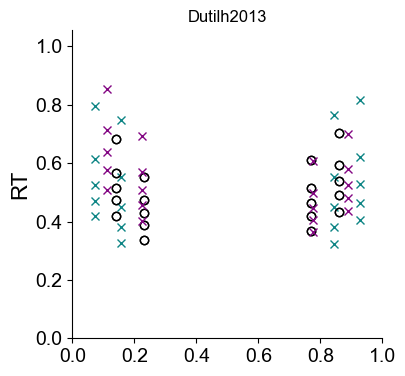

In [29]:
data_dir = "/Users/wangjiashun/Desktop/Reserach on SAT/datasets/Evans2021/Dutilh2013/dataBySubject/sub"
sample_size = 32
figure, ax = plt.subplots(figsize=(4,4))

DDM_OUM_QP_plot(ax=ax,  sample_size=sample_size, dataset="Dutilh2013")

#ax.legend()

<Axes: title={'center': 'Rae2014'}, ylabel='RT'>

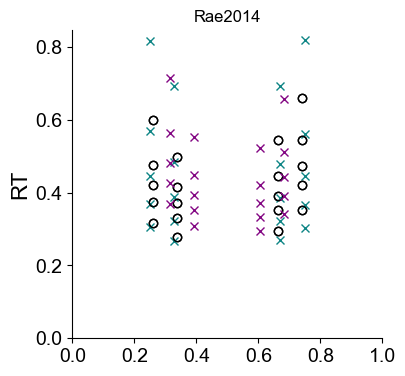

In [14]:
data_dir = "/Users/wangjiashun/Desktop/Reserach on SAT/datasets/Evans2021/Rae2014/dataBySubject/sub"
sample_size = 34
figure, ax = plt.subplots(figsize=(4,4))

DDM_OUM_QP_plot(ax=ax,  sample_size=sample_size, dataset="Rae2014")

#ax.legend()

In [16]:
def DDM_OUM_QP_plot_EJ(freq,label, dataset="Wagenmakers2008", sample_size=16,  correct = 'Correct',corrects = [True, False],
                       cond = 'Cond', conds = ['Speed', 'Accuracy'],rt = 'Time',ax=None, legend = False):
    if ax is None:
        ax = plt.gca()
    
    quantiles = [.1, .3, .5, .7, .9]
    
    data_dir = "/Users/wangjiashun/Desktop/Research_on_SAT/datasets/transformed/Wagenmakers2008/dataByFreq/Freq"+str(freq)+"/sub"    

    ## behavioral data
    RT_cor_s, RT_cor_a, RT_err_s, RT_err_a, nums = get_RT_quantile(dataset=dataset, data_dir = data_dir,sample_size= sample_size, 
                                                                   correct = correct, corrects = corrects,
                                                                   cond = cond, conds = conds, rt = rt)
    #print(RT_cor_s, RT_cor_a, RT_err_s, RT_err_a, nums)
    line_1, = ax.plot([nums[0]/(nums[0]+nums[2])]*5, RT_cor_s,"o", color = 'black', fillstyle = 'none')
    ax.plot([nums[1]/(nums[1]+nums[3])]*5, RT_cor_a,"o", color = 'black', fillstyle = 'none')
    ax.plot([nums[2]/(nums[0]+nums[2])]*5, RT_err_s,"o", color = 'black', fillstyle = 'none')
    ax.plot([nums[3]/(nums[1]+nums[3])]*5, RT_err_a,"o", color = 'black', fillstyle = 'none')

    ## data generated from DDM
    RT_cor_s, RT_cor_a, RT_err_s, RT_err_a, nums = get_RT_quantile_DDM(dataset=dataset, sample_size= sample_size, 
                                                                   correct = correct, corrects = corrects,
                                                                   cond = cond, conds = conds, rt = rt,freq = freq)
    #print(RT_cor_s, RT_cor_a, RT_err_s, RT_err_a, nums)

    line_2, = ax.plot([nums[0]/(nums[0]+nums[2])]*5, RT_cor_s,"x", color = '#0E8585', fillstyle = 'none')
    ax.plot([nums[1]/(nums[1]+nums[3])]*5, RT_cor_a,"x", color = '#0E8585', fillstyle = 'none')
    ax.plot([nums[2]/(nums[0]+nums[2])]*5, RT_err_s,"x", color = '#0E8585', fillstyle = 'none')
    ax.plot([nums[3]/(nums[1]+nums[3])]*5, RT_err_a,"x", color = '#0E8585', fillstyle = 'none')

    ## data generated from OUM
    RT_cor_s, RT_cor_a, RT_err_s, RT_err_a, nums = get_RT_quantile_OUM2v2k2ter(dataset=dataset, sample_size= sample_size, 
                                                                   correct = correct, corrects = corrects,
                                                                   cond = cond, conds = conds, rt = rt,freq = freq)
    line_3, = ax.plot([nums[0]/(nums[0]+nums[2])]*5, RT_cor_s,"x", color = '#830783', fillstyle = 'none')
    ax.plot([nums[1]/(nums[1]+nums[3])]*5, RT_cor_a,"x", color = '#830783', fillstyle = 'none')
    ax.plot([nums[2]/(nums[0]+nums[2])]*5, RT_err_s,"x", color = '#830783', fillstyle = 'none')
    ax.plot([nums[3]/(nums[1]+nums[3])]*5, RT_err_a,"x", color = '#830783', fillstyle = 'none')
     
    # limits
    ax.set_xlim(0,1)
    ax.set_ylim(0,)
    #ax.set_xlabel("Probability of Response")
    ax.set_ylabel("RT",fontsize = 16)
    ax.set_title(label,fontsize = 20, weight='bold', fontname='Arial')
    
    ax.spines[['right', 'top']].set_visible(False)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.legend().set_visible(False)
    if legend:
        ax.legend(handles = [line_1, line_2, line_3], labels =["Data", "DDM", "OUM"], loc='upper left', 
                  bbox_to_anchor=(1, 1),fontsize=16, frameon=False)
    return(ax)


In [17]:
Frequencies = [1,  2, 3,  4,  5,  6]
participants = [1,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17]

NameError: name 'get_RT_quantile_OUM2v2k2ter' is not defined

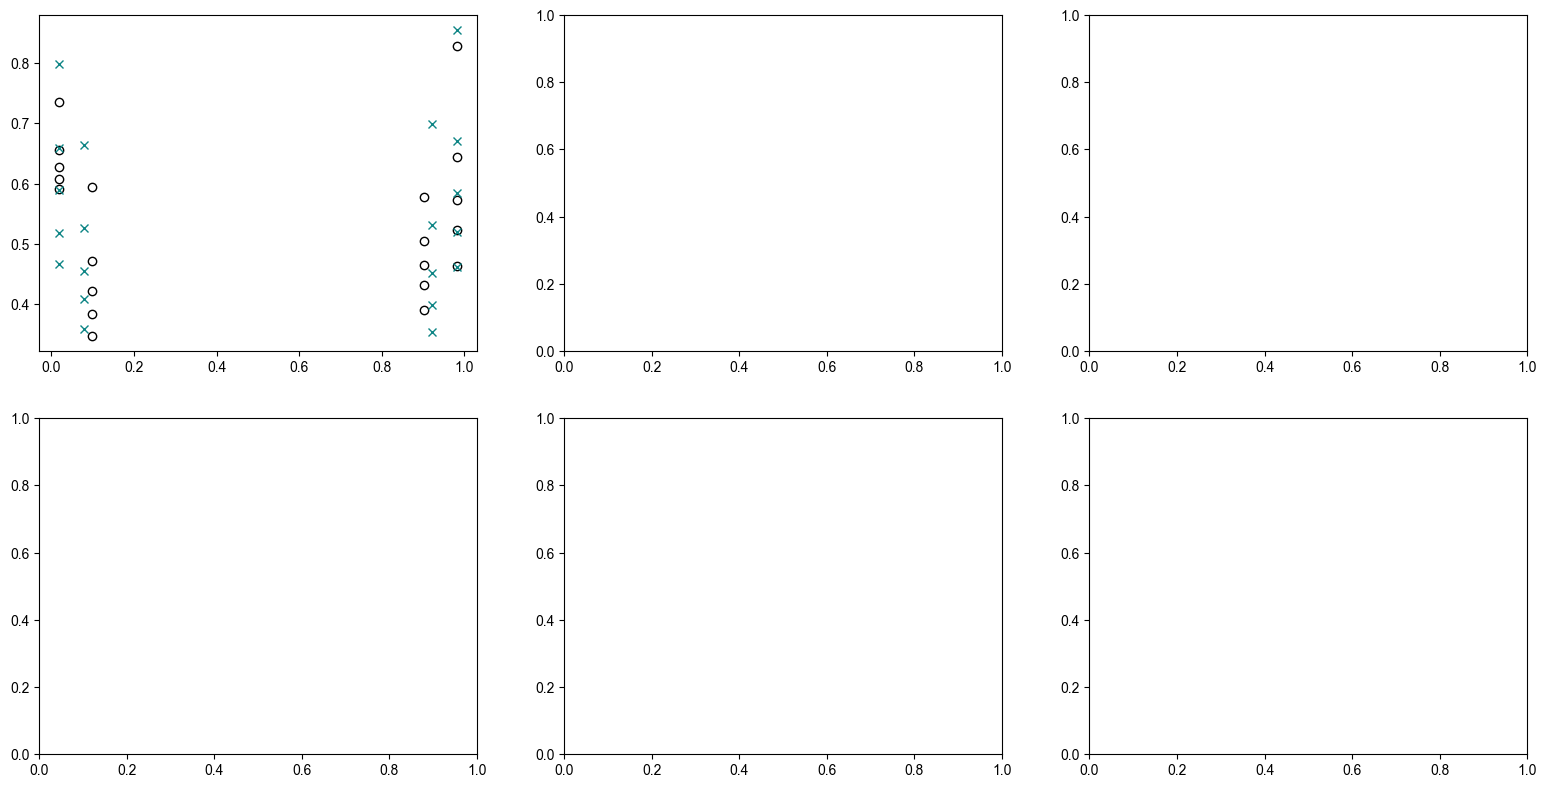

In [18]:
fig, ax = plt.subplots(2,3,figsize=[6.4*3, 4.8*2])

DDM_OUM_QP_plot_EJ(freq=1,label="High Frequency Word", ax = ax[0,0])
DDM_OUM_QP_plot_EJ(freq=2,label="Low Frequency Word", ax = ax[0,1])
DDM_OUM_QP_plot_EJ(freq=3,label="Very Low Frequency Word", ax = ax[0,2])
DDM_OUM_QP_plot_EJ(freq=4,label="High Frequency Nonword", ax = ax[1,0])
DDM_OUM_QP_plot_EJ(freq=5,label="Low Frequency Nonword", ax = ax[1,1])
DDM_OUM_QP_plot_EJ(freq=6,label="Very Low Frequency Nonword", ax = ax[1,2], legend = True)

ax[1,0].set_xlabel("Probability of Response",fontsize = 16)
ax[1,1].set_xlabel("Probability of Response",fontsize = 16)
ax[1,2].set_xlabel("Probability of Response",fontsize = 16)

#plt.legend(labels =["Data", "DDM", "OUM"], loc='upper left', bbox_to_anchor=(1, 1),fontsize=16, frameon=False)
#ax[1,2].set_xticks([])
#ax[1,2].axis('off')

In [33]:
def DDM_OUM_QP_plot_EJ(freq,label, dataset="Wagenmakers2008", sample_size=16,  correct = 'Correct',corrects = [True, False],
                       cond = 'Cond', conds = ['Speed', 'Accuracy'],rt = 'Time',ax=None, legend = False):
    if ax is None:
        ax = plt.gca()
    
    quantiles = [.1, .3, .5, .7, .9]
    
    data_dir = "/Users/wangjiashun/Desktop/Research_on_SAT/datasets/transformed/Wagenmakers2008/dataByFreq/Freq"+str(freq)+"/sub"    

    ## behavioral data
    RT_cor_s, RT_cor_a, RT_err_s, RT_err_a, nums = get_RT_quantile(dataset=dataset, data_dir = data_dir,sample_size= sample_size, 
                                                                   correct = correct, corrects = corrects,
                                                                   cond = cond, conds = conds, rt = rt)
    #print(RT_cor_s, RT_cor_a, RT_err_s, RT_err_a, nums)
    line_1, = ax.plot([nums[0]/(nums[0]+nums[2])]*5, RT_cor_s,"o", color = 'black', fillstyle = 'none')
    ax.plot([nums[1]/(nums[1]+nums[3])]*5, RT_cor_a,"o", color = 'black', fillstyle = 'none')
    ax.plot([nums[2]/(nums[0]+nums[2])]*5, RT_err_s,"o", color = 'black', fillstyle = 'none')
    ax.plot([nums[3]/(nums[1]+nums[3])]*5, RT_err_a,"o", color = 'black', fillstyle = 'none')

    ## data generated from DDM
    RT_cor_s, RT_cor_a, RT_err_s, RT_err_a, nums = get_RT_quantile_DDM(dataset=dataset, sample_size= sample_size, 
                                                                   correct = correct, corrects = corrects,
                                                                   cond = cond, conds = conds, rt = rt,freq = freq)
    #print(RT_cor_s, RT_cor_a, RT_err_s, RT_err_a, nums)

    line_2, = ax.plot([nums[0]/(nums[0]+nums[2])]*5, RT_cor_s,"x", color = '#0E8585', fillstyle = 'none')
    ax.plot([nums[1]/(nums[1]+nums[3])]*5, RT_cor_a,"x", color = '#0E8585', fillstyle = 'none')
    ax.plot([nums[2]/(nums[0]+nums[2])]*5, RT_err_s,"x", color = '#0E8585', fillstyle = 'none')
    ax.plot([nums[3]/(nums[1]+nums[3])]*5, RT_err_a,"x", color = '#0E8585', fillstyle = 'none')

    ## data generated from OUM
    RT_cor_s, RT_cor_a, RT_err_s, RT_err_a, nums = get_RT_quantile_OUM2v2k2ter(dataset=dataset, sample_size= sample_size, 
                                                                   correct = correct, corrects = corrects,
                                                                   cond = cond, conds = conds, rt = rt,freq = freq)
    line_3, = ax.plot([nums[0]/(nums[0]+nums[2])]*5, RT_cor_s,"x", color = '#830783', fillstyle = 'none')
    ax.plot([nums[1]/(nums[1]+nums[3])]*5, RT_cor_a,"x", color = '#830783', fillstyle = 'none')
    ax.plot([nums[2]/(nums[0]+nums[2])]*5, RT_err_s,"x", color = '#830783', fillstyle = 'none')
    ax.plot([nums[3]/(nums[1]+nums[3])]*5, RT_err_a,"x", color = '#830783', fillstyle = 'none')
     
    # limits
    ax.set_xlim(0,1)
    ax.set_ylim(0,)
    #ax.set_xlabel("Probability of Response")
    ax.set_ylabel("RT",fontsize = 16)
    ax.set_title(label,fontsize = 20, weight='bold', fontname='Arial')
    
    ax.spines[['right', 'top']].set_visible(False)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.legend().set_visible(False)
    if legend:
        ax.legend(handles = [line_1, line_2, line_3], labels =["Data", "DDM", "OUM"], loc='upper left', 
                  bbox_to_anchor=(1, 1),fontsize=16, frameon=False)
    return(ax)


NameError: name 'DDM_OUM_QP_plot_EJ' is not defined

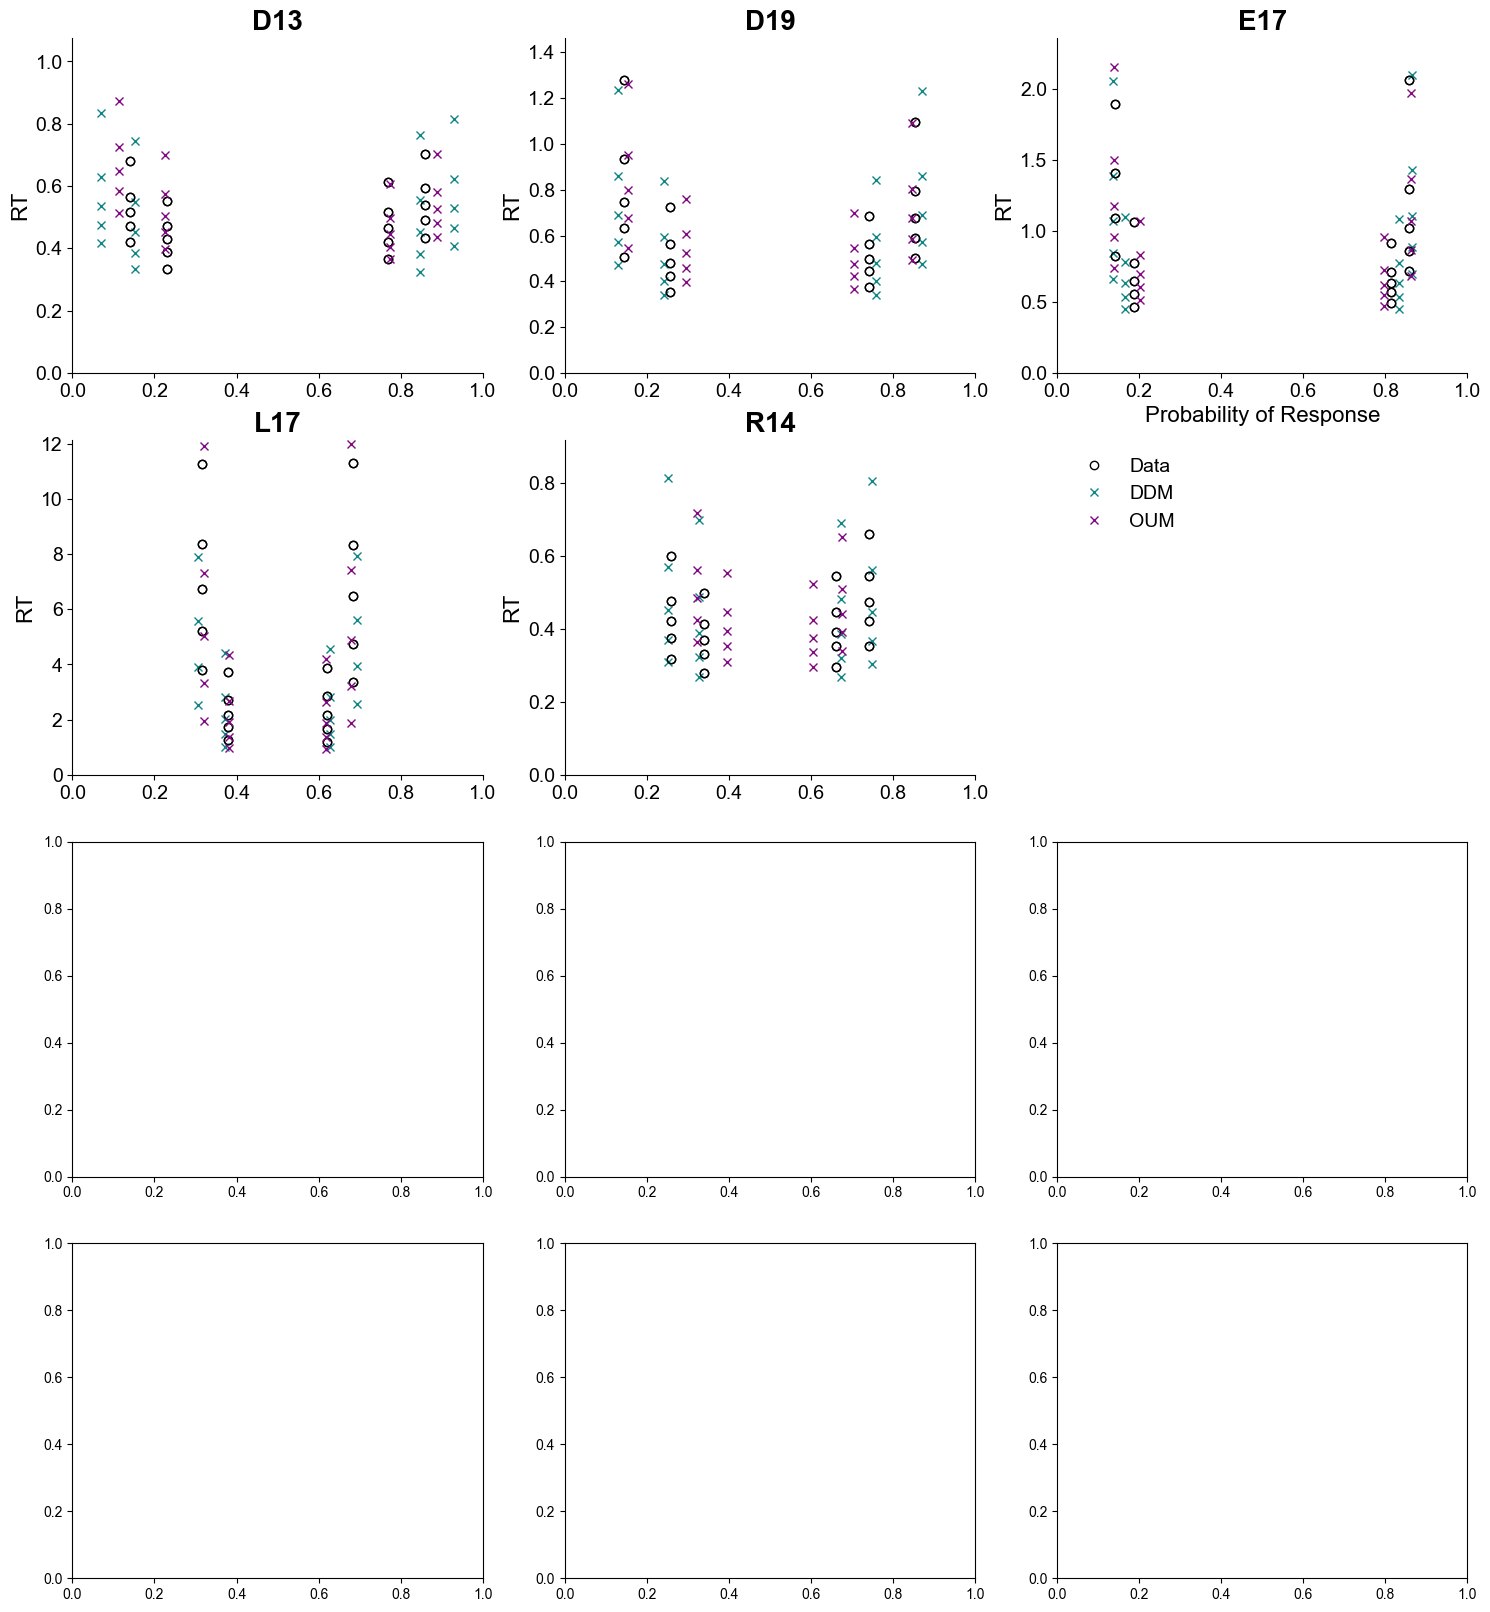

In [31]:
dataset_names = ['D13', 'D19', 'E17', 'L17', 'R14', 'W08']

fig, ax = plt.subplots(4,3,figsize=[18, 20])

DDM_OUM_QP_plot(ax=ax[0,0], sample_size=32, dataset="Dutilh2013")
DDM_OUM_QP_plot(ax=ax[0,1], sample_size=20, dataset="Dutilh2019")
DDM_OUM_QP_plot(ax=ax[0,2], sample_size=47, dataset="Evans2017")
DDM_OUM_QP_plot(ax=ax[1,0], sample_size=38, dataset="Lerche2017")
DDM_OUM_QP_plot(ax=ax[1,1], sample_size=34, dataset="Rae2014")


for i in range(3):
    ax[0,i].set_title(dataset_names[i],fontsize = 20, weight='bold', fontname='Arial')
    
for i in range(2):
    ax[1,i].set_title(dataset_names[i+3],fontsize = 20, weight='bold', fontname='Arial')

#ax[1,0].set_xlabel("Probability of Response",fontsize = 16)
#ax[1,1].set_xlabel("Probability of Response",fontsize = 16)
ax[0,2].set_xlabel("Probability of Response",fontsize = 16)

ax[1,2].set_xticks([])
ax[1,2].axis('off')
ax[1,1].legend(loc='upper left', bbox_to_anchor=(1.2, 1),fontsize=14,frameon=False) #labels =["Data", "DDM", "OUM"], 

#l = plt.legend(handles[2:4], labels[2:4], bbox_to_anchor=(1.05, 2.1), loc=2, borderaxespad=0.,fontsize=16, frameon=False)
#axes[1,1].legend(labels =["Data", "DDM", "OUM"], loc='upper left', bbox_to_anchor=(0, 1),fontsize=16, frameon=False)


DDM_OUM_QP_plot_EJ(freq=1,label="High Frequency Word", ax = ax[2,0])
DDM_OUM_QP_plot_EJ(freq=2,label="Low Frequency Word", ax = ax[2,1])
DDM_OUM_QP_plot_EJ(freq=3,label="Very Low Frequency Word", ax = ax[2,2])
DDM_OUM_QP_plot_EJ(freq=4,label="High Frequency Nonword", ax = ax[3,0])
DDM_OUM_QP_plot_EJ(freq=5,label="Low Frequency Nonword", ax = ax[3,1])
DDM_OUM_QP_plot_EJ(freq=6,label="Very Low Frequency Nonword", ax = ax[3,2])

ax[3,0].set_xlabel("Probability of Response",fontsize = 16)
ax[3,1].set_xlabel("Probability of Response",fontsize = 16)
ax[3,2].set_xlabel("Probability of Response",fontsize = 16)

#plt.legend(labels =["Data", "DDM", "OUM"], loc='upper left', bbox_to_anchor=(1, 1),fontsize=16, frameon=False)
#ax[1,2].set_xticks([])
#ax[1,2].axis('off')


plt.rcParams['pdf.fonttype']=42
plt.rcParams['ps.fonttype']=42

#plt.savefig("/Users/wangjiashun/Desktop/Research_on_SAT/Draft/Supplementary Figures/sup_fig3.pdf")

ax[0,0].text(x=-0.2,y=1.02, s="a", fontsize = 30, weight='bold')
ax[2,0].text(x=-0.2,y=1.02, s="b", fontsize = 30, weight='bold')



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


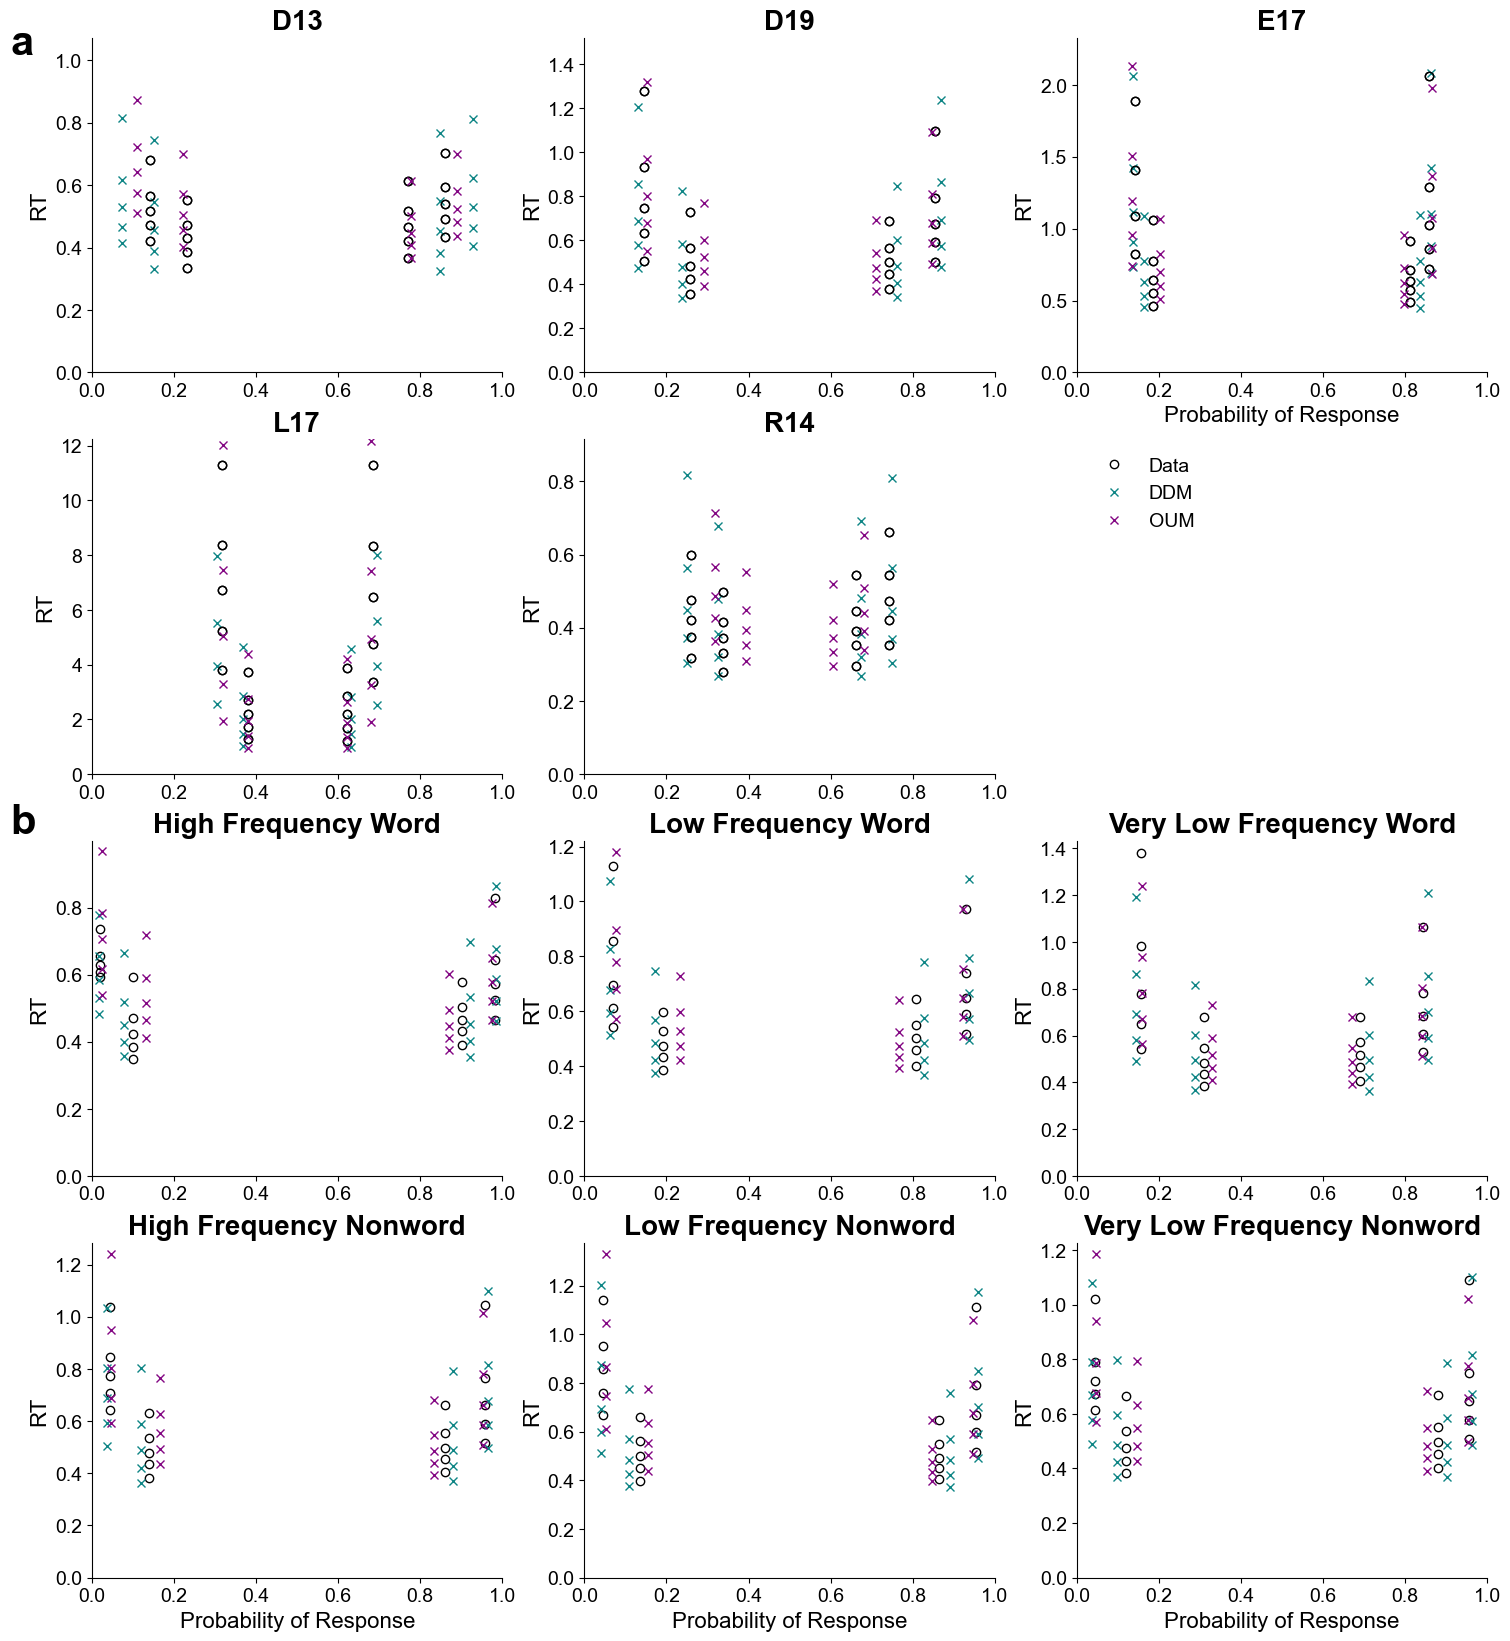

In [34]:
dataset_names = ['D13', 'D19', 'E17', 'L17', 'R14', 'W08']

fig, ax = plt.subplots(4,3,figsize=[18, 20])

DDM_OUM_QP_plot(ax=ax[0,0], sample_size=32, dataset="Dutilh2013")
DDM_OUM_QP_plot(ax=ax[0,1], sample_size=20, dataset="Dutilh2019")
DDM_OUM_QP_plot(ax=ax[0,2], sample_size=47, dataset="Evans2017")
DDM_OUM_QP_plot(ax=ax[1,0], sample_size=38, dataset="Lerche2017")
DDM_OUM_QP_plot(ax=ax[1,1], sample_size=34, dataset="Rae2014")


for i in range(3):
    ax[0,i].set_title(dataset_names[i],fontsize = 20, weight='bold', fontname='Arial')
    
for i in range(2):
    ax[1,i].set_title(dataset_names[i+3],fontsize = 20, weight='bold', fontname='Arial')

#ax[1,0].set_xlabel("Probability of Response",fontsize = 16)
#ax[1,1].set_xlabel("Probability of Response",fontsize = 16)
ax[0,2].set_xlabel("Probability of Response",fontsize = 16)

ax[1,2].set_xticks([])
ax[1,2].axis('off')
ax[1,1].legend(loc='upper left', bbox_to_anchor=(1.2, 1),fontsize=14,frameon=False) #labels =["Data", "DDM", "OUM"], 

#l = plt.legend(handles[2:4], labels[2:4], bbox_to_anchor=(1.05, 2.1), loc=2, borderaxespad=0.,fontsize=16, frameon=False)
#axes[1,1].legend(labels =["Data", "DDM", "OUM"], loc='upper left', bbox_to_anchor=(0, 1),fontsize=16, frameon=False)


DDM_OUM_QP_plot_EJ(freq=1,label="High Frequency Word", ax = ax[2,0])
DDM_OUM_QP_plot_EJ(freq=2,label="Low Frequency Word", ax = ax[2,1])
DDM_OUM_QP_plot_EJ(freq=3,label="Very Low Frequency Word", ax = ax[2,2])
DDM_OUM_QP_plot_EJ(freq=4,label="High Frequency Nonword", ax = ax[3,0])
DDM_OUM_QP_plot_EJ(freq=5,label="Low Frequency Nonword", ax = ax[3,1])
DDM_OUM_QP_plot_EJ(freq=6,label="Very Low Frequency Nonword", ax = ax[3,2])

ax[3,0].set_xlabel("Probability of Response",fontsize = 16)
ax[3,1].set_xlabel("Probability of Response",fontsize = 16)
ax[3,2].set_xlabel("Probability of Response",fontsize = 16)

#plt.legend(labels =["Data", "DDM", "OUM"], loc='upper left', bbox_to_anchor=(1, 1),fontsize=16, frameon=False)
#ax[1,2].set_xticks([])
#ax[1,2].axis('off')


plt.rcParams['pdf.fonttype']=42
plt.rcParams['ps.fonttype']=42

#plt.savefig("/Users/wangjiashun/Desktop/Research_on_SAT/Draft/Supplementary Figures/sup_fig3.pdf")

ax[0,0].text(x=-0.2,y=1.02, s="a", fontsize = 30, weight='bold')
ax[2,0].text(x=-0.2,y=1.02, s="b", fontsize = 30, weight='bold')


plt.rcParams['pdf.fonttype']=42
plt.rcParams['ps.fonttype']=42

plt.savefig("/Users/wangjiashun/Desktop/Research_on_SAT/Draft/Supplementary Figures/sup_fig3.pdf")

(0.0, 1.0, 0.0, 1.0)

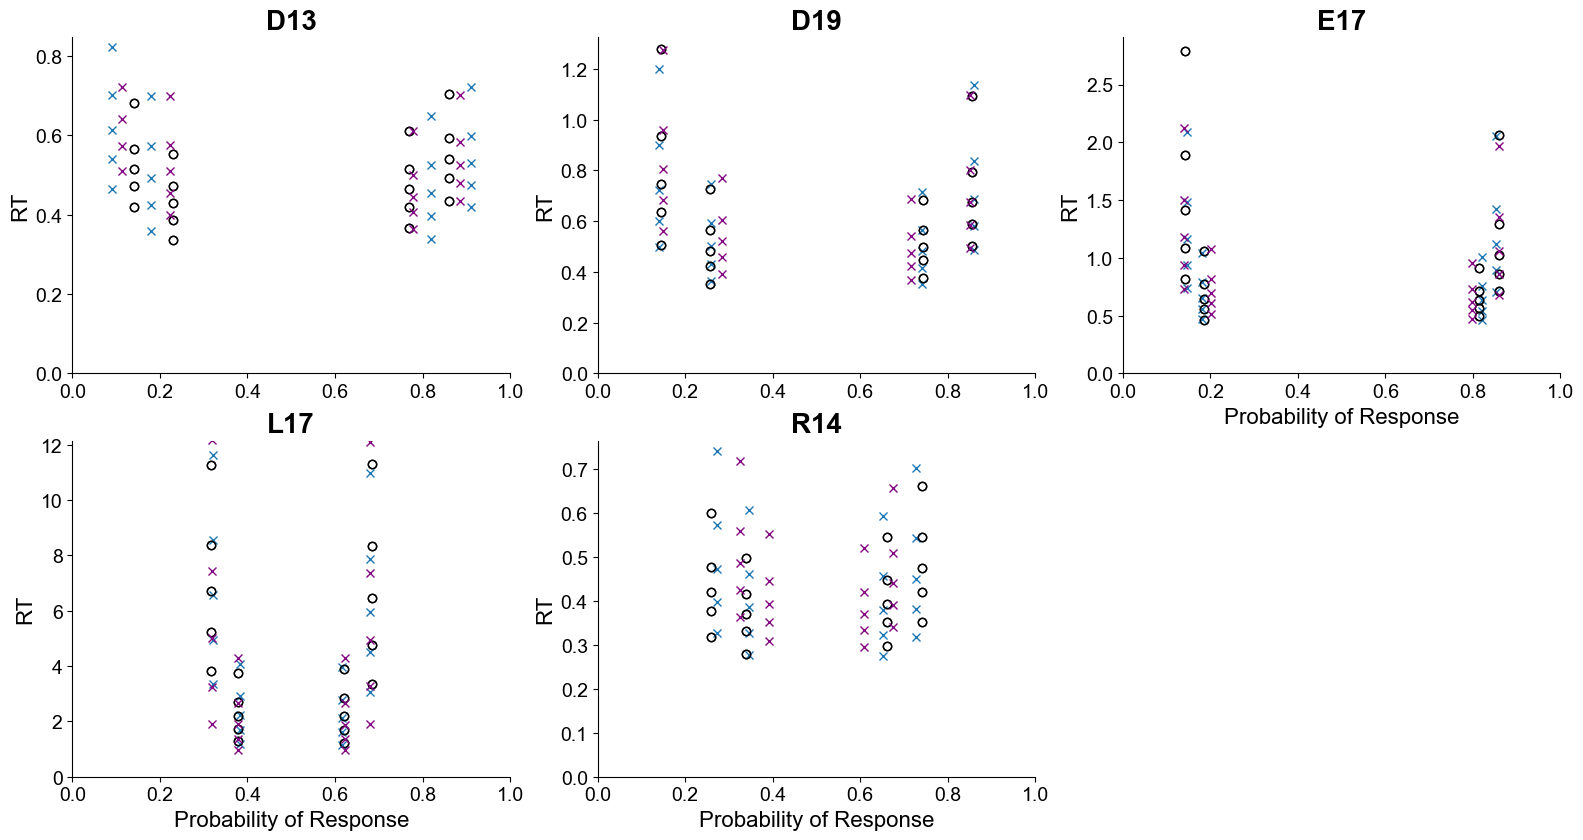

In [33]:


dataset_names = ['D13', 'D19', 'E17', 'L17', 'R14', 'W08']

fig, ax = plt.subplots(2,3,figsize=[6.4*3, 4.8*2])

DDM2v2a2c2ter_OUM_QP_plot(ax=ax[0,0], sample_size=32, dataset="Dutilh2013")
DDM2v2a2c2ter_OUM_QP_plot(ax=ax[0,1], sample_size=20, dataset="Dutilh2019")
DDM2v2a2c2ter_OUM_QP_plot(ax=ax[0,2], sample_size=47, dataset="Evans2017")
DDM2v2a2c2ter_OUM_QP_plot(ax=ax[1,0], sample_size=38, dataset="Lerche2017")
DDM2v2a2c2ter_OUM_QP_plot(ax=ax[1,1], sample_size=34, dataset="Rae2014")


for i in range(3):
    ax[0,i].set_title(dataset_names[i],fontsize = 20, weight='bold', fontname='Arial')
    
for i in range(2):
    ax[1,i].set_title(dataset_names[i+3],fontsize = 20, weight='bold', fontname='Arial')

ax[1,0].set_xlabel("Probability of Response",fontsize = 16)
ax[1,1].set_xlabel("Probability of Response",fontsize = 16)
ax[0,2].set_xlabel("Probability of Response",fontsize = 16)

ax[1,2].set_xticks([])
ax[1,2].axis('off')
#l = plt.legend(handles[2:4], labels[2:4], bbox_to_anchor=(1.05, 2.1), loc=2, borderaxespad=0.,fontsize=16, frameon=False)
#axes[1,1].legend(labels =["Data", "DDM", "OUM"], loc='upper left', bbox_to_anchor=(0, 1),fontsize=16, frameon=False)